[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ahmedsalim3/iaifi-hackathon-2025/blob/main/notebooks/dataset-exploration.ipynb)

If you are on colab, you may need to download the datasets, refer to [data access](https://ahmedsalim3.github.io/iaifi-hackathon-2025/datasets/#data-access) to know how to get them ready.

## Dataset Exploration & Analysis

In this Notebook, we will load, check out, and analyze two key datasets:

- A **Source Dataset** from **IllustrisTNG**, which is a simulation
- A **Target Dataset** from Galaxy Zoo 2, which uses real-world data

We will also has visuals for how the different classes are distributed and shows how we can calculate class weights

In [1]:
import json, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms

from nebula.data.dataset import SourceDataset, TargetDataset
from nebula.data.normalization import compute_dataset_mean_std
from nebula.data.class_weights import compute_class_weights

In [2]:
# --- Define paths ---
DATA_ROOT = "../data"
SRC_JSON = Path(DATA_ROOT) / "source" / "labels_master.json"
TGT_JSON = Path(DATA_ROOT) / "target" / "labels_master_top_n.json"

In [3]:
# --- Inspect raw JSON entries ---
with open(SRC_JSON, "r") as f:
    src_data = json.load(f)

with open(TGT_JSON, "r") as f:
    tgt_data = json.load(f)

print("Source dataset sample:\n", json.dumps(src_data[0], indent=2))
print("\nTarget dataset sample:\n", json.dumps(tgt_data[0], indent=2))

Source dataset sample:
 {
  "image_path": "llustrisTNG/subhalo_0.png",
  "subhalo_id": 0,
  "mass": 3682930000000.0,
  "star_forming": false,
  "has_agn": false,
  "is_compact": true,
  "metallicity": 0.03570494,
  "classification": "elliptical",
  "is_metalrich": true
}

Target dataset sample:
 {
  "image_path": "data/target/images_gz2/images/76446.jpg",
  "objid": 587734948058431657,
  "classification": "elliptical",
  "metrics": {
    "artifact_prob": 0.0,
    "smooth_prob": 1.0,
    "features_prob": 0.0,
    "edgeon_prob": 0.0,
    "spiral_prob": 0.0,
    "nospiral_prob": 1.0,
    "irregular_prob": 0.0,
    "merger_prob": 0.0,
    "disturbed_prob": 0.0,
    "odd_prob": 0.0841383614728033
  }
}


In [4]:
# --- Load datasets ---
train_transform = transforms.Compose([
    transforms.Resize((128,128)), # image size
    transforms.ToTensor(),
])

src_train = SourceDataset(DATA_ROOT, transform=train_transform, split="train")
tgt_train = TargetDataset(DATA_ROOT, transform=train_transform, split="train")

print(src_train.summary)
print(tgt_train.summary)

SourceDataset
split: train
root: ../data/source
# images: 1240
# classes: 3
image dims: 448x448
transform: Yes
class distribution: elliptical: 269 (21.7%), spiral: 853 (68.8%), irregular: 118 (9.5%)

TargetDataset
split: train
root: ../data/target
# images: 2995
# classes: 3
image dims: 424x424
transform: Yes
class distribution: elliptical: 730 (24.4%), spiral: 1587 (53.0%), irregular: 678 (22.6%)



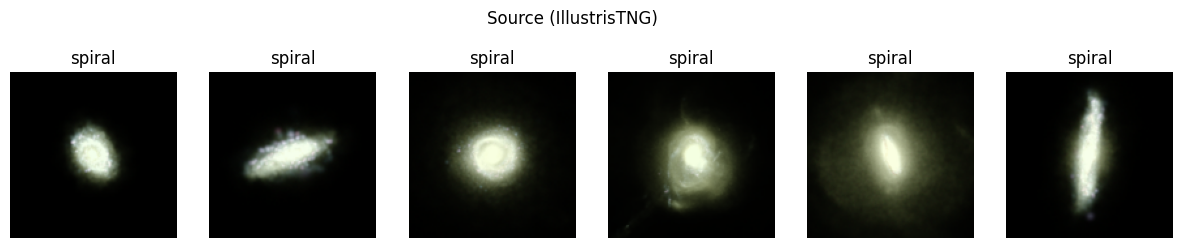

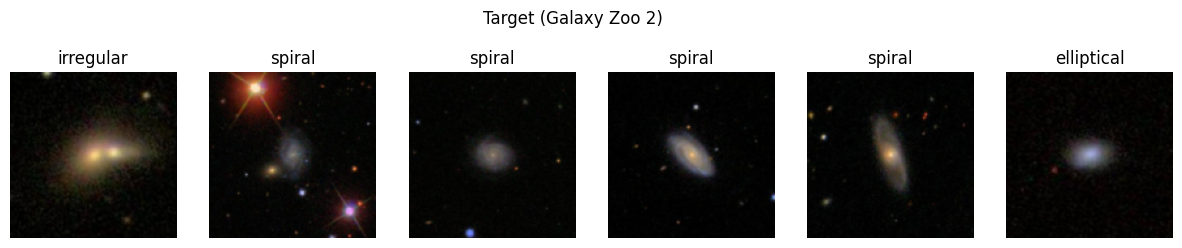

In [5]:
# --- Visualize some dataset samples ---
def show_samples(dataset, n=6, title="Samples"):
    _, axs = plt.subplots(1, n, figsize=(15,3))
    for i in range(n):
        img_tensor, label = dataset[random.randint(0, len(dataset)-1)]
        img_pil = transforms.ToPILImage()(img_tensor)
        axs[i].imshow(img_pil)
        axs[i].set_title(dataset.idx2label[label.item()])
        axs[i].axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(src_train, title="Source (IllustrisTNG)")
show_samples(tgt_train, title="Target (Galaxy Zoo 2)")

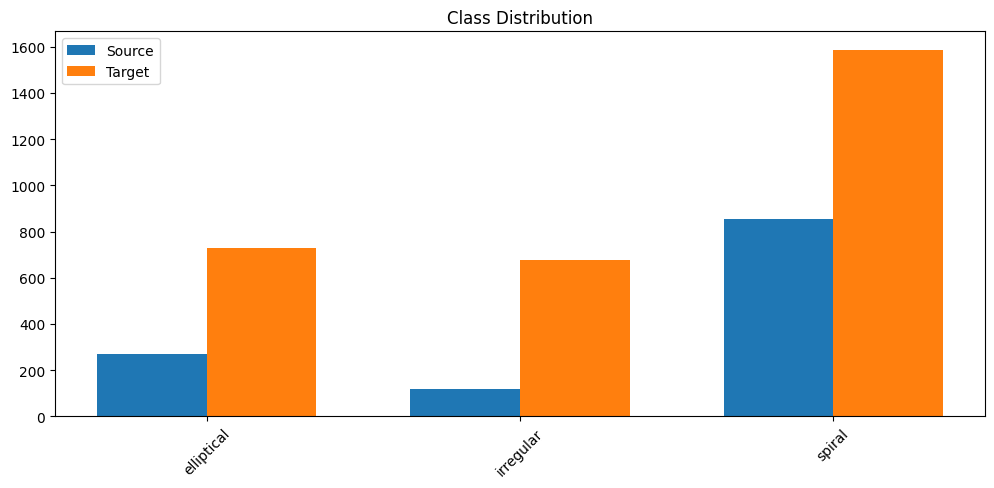

In [6]:
# --- Class distributions ---
src_dist = {k: v["count"] for k,v in src_train.get_class_distribution().items()}
tgt_dist = {k: v["count"] for k,v in tgt_train.get_class_distribution().items()}

labels = sorted(list(src_dist.keys()))
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12,5))
plt.bar(x - width/2, [src_dist[l] for l in labels], width, label="Source")
plt.bar(x + width/2, [tgt_dist[l] for l in labels], width, label="Target")

plt.xticks(x, labels, rotation=45)
plt.title("Class Distribution")
plt.legend()
plt.show()

## Class Weights

In machine learning, class weights are often used to address dataset imbalance. We'll compute both "effective" and "balanced" class weights for both the source and target datasets and visualize them alongside their respective class distributions.

This technique ensures:

- Minority classes are assigned higher weights
- Majority classes get lower weights

These weights can be passed to the loss function so the model pays more attention to underrepresented classes. This way, incorrect predictions on rare classes are penalized more, helping the model not just favor the "popular" ones.

### 1. Balanced Method

Source class weights: tensor([0.8345, 0.2632, 1.9023])
Target class weights: tensor([1.1826, 0.5440, 1.2734])


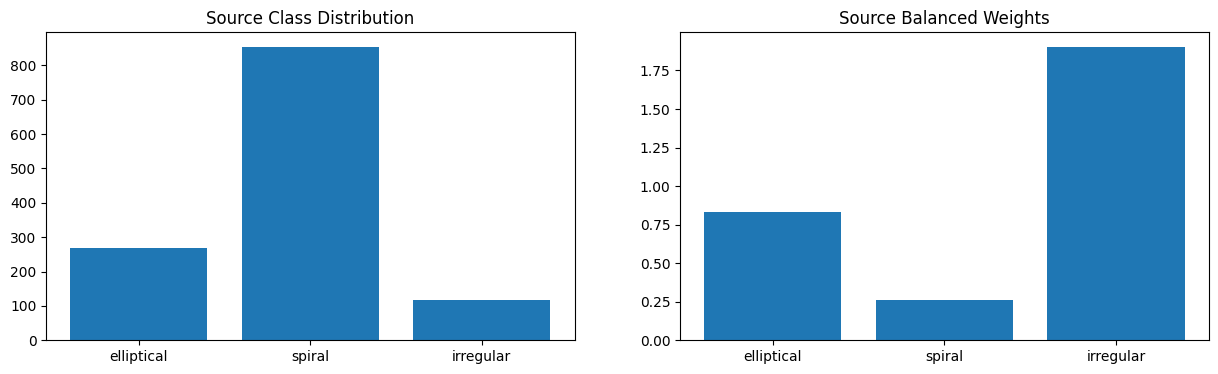

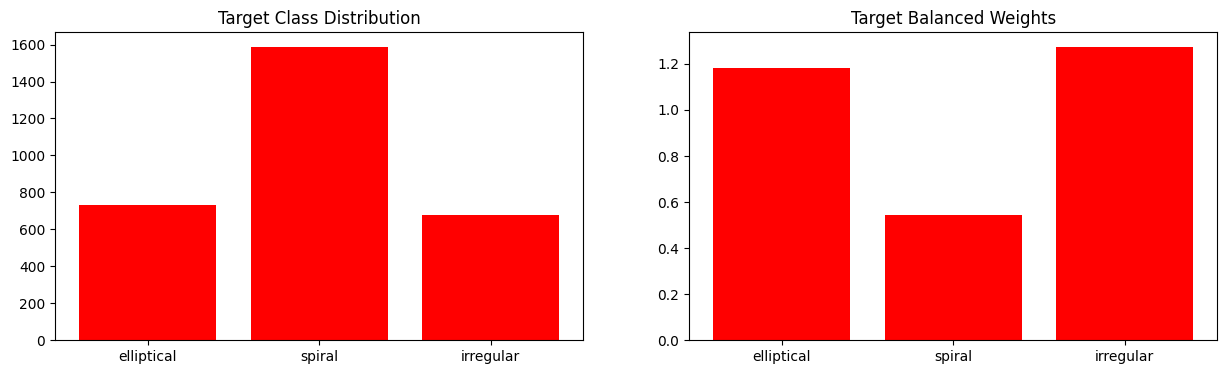

In [7]:
# Get labels and class names from the dataset objects
labels_src = [s['label'] for s in src_train.samples]
labels_tgt = [s['label'] for s in tgt_train.samples]

class_names = [src_train.idx2label[i] for i in range(src_train.num_ids)]

# compute weights
class_weights_src = compute_class_weights(labels_src, method="balanced")
class_weights_tgt = compute_class_weights(labels_tgt, method="balanced")
print("Source class weights:", class_weights_src)
print("Target class weights:", class_weights_tgt)

# --- Plotting the distributions ---
src_dist = src_train.get_class_distribution()
tgt_dist = tgt_train.get_class_distribution()

# Reorder distribution counts to match the weights tensor
src_counts = [src_dist[name]["count"] for name in class_names]
tgt_counts = [tgt_dist[name]["count"] for name in class_names]

# source dataset
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.bar(range(len(src_counts)), src_counts)
ax1.set_title("Source Class Distribution")
ax1.set_xticks(range(len(class_names)), class_names)
ax2.bar(range(len(class_weights_src)), class_weights_src.numpy())
ax2.set_title("Source Balanced Weights")
ax2.set_xticks(range(len(class_names)), class_names)
plt.show()

# target dataset
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.bar(range(len(tgt_counts)), tgt_counts, color="red")
ax1.set_title("Target Class Distribution")
ax1.set_xticks(range(len(class_names)), class_names)
ax2.bar(range(len(class_weights_tgt)), class_weights_tgt.numpy(), color="red")
ax2.set_title("Target Balanced Weights")
ax2.set_xticks(range(len(class_names)), class_names)
plt.show()


### 2. Effective Method

The effective method uses the **"effective number of samples"** method with β=0.9999. This adjusts weights based on how many examples each class has, so the model doesn't get biased toward the majority class. The method comes from the paper [_Class-Balanced Loss Based on Effective Number of Samples_](https://arxiv.org/pdf/1901.05555), and its official [implementation in PyTorch](https://github.com/vandit15/Class-balanced-loss-pytorch/blob/master/class_balanced_loss.py#L53-L91)

Source class weights: tensor([0.8363, 0.2715, 1.8922])
Target class weights: tensor([1.1748, 0.5636, 1.2616])


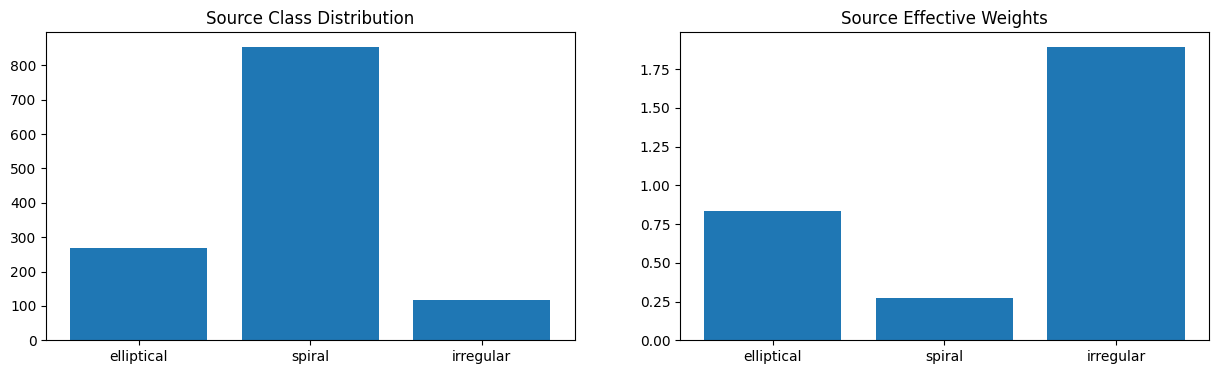

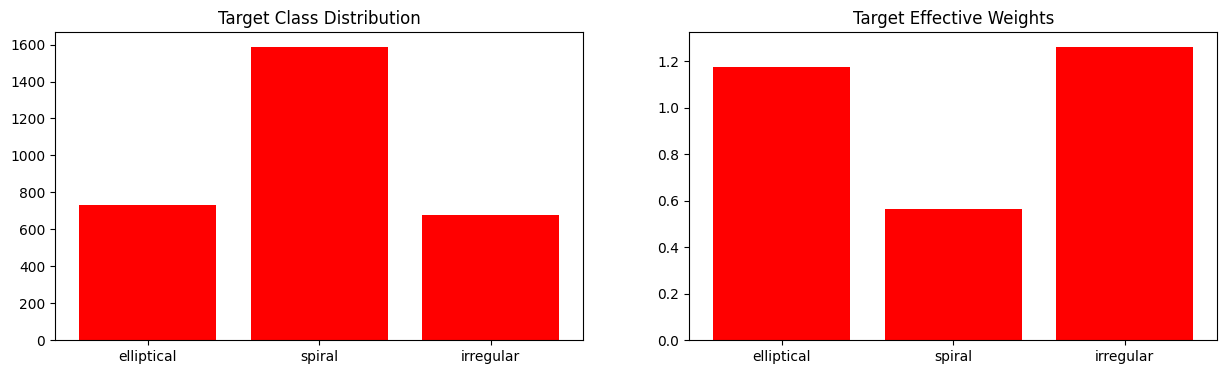

In [8]:
# compute weights
class_weights_src = compute_class_weights(labels_src, method="effective")
class_weights_tgt = compute_class_weights(labels_tgt, method="effective")
print("Source class weights:", class_weights_src)
print("Target class weights:", class_weights_tgt)

# --- Plotting the distributions ---
src_dist = src_train.get_class_distribution()
tgt_dist = tgt_train.get_class_distribution()

# Reorder distribution counts to match the weights tensor
src_counts = [src_dist[name]["count"] for name in class_names]
tgt_counts = [tgt_dist[name]["count"] for name in class_names]

# source dataset
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.bar(range(len(src_counts)), src_counts)
ax1.set_title("Source Class Distribution")
ax1.set_xticks(range(len(class_names)), class_names)
ax2.bar(range(len(class_weights_src)), class_weights_src.numpy())
ax2.set_title("Source Effective Weights")
ax2.set_xticks(range(len(class_names)), class_names)
plt.show()

# target dataset
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.bar(range(len(tgt_counts)), tgt_counts, color="red")
ax1.set_title("Target Class Distribution")
ax1.set_xticks(range(len(class_names)), class_names)
ax2.bar(range(len(class_weights_tgt)), class_weights_tgt.numpy(), color="red")
ax2.set_title("Target Effective Weights")
ax2.set_xticks(range(len(class_names)), class_names)
plt.show()

## Normalization

In [9]:
# --- Compute normalization statistics (mean/std) ---

# inorder to compute the mean/std, the images are not transformed
src_train = SourceDataset(DATA_ROOT, split="train")
tgt_train = TargetDataset(DATA_ROOT, split="train")

mean, std = compute_dataset_mean_std(src_train)
print("Source mean:", mean.tolist())
print("Source std:", std.tolist())

mean, std = compute_dataset_mean_std(tgt_train)
print("Target mean:", mean.tolist())
print("Target std:", std.tolist())


Computing mean/std: 100%|██████████| 1240/1240 [00:06<00:00, 187.06it/s]


Source mean: [0.10835663229227066, 0.11768525838851929, 0.09033632278442383]
Source std: [0.20970022678375244, 0.2209458202123642, 0.19074109196662903]


Computing mean/std: 100%|██████████| 2995/2995 [00:06<00:00, 462.92it/s]

Target mean: [0.04580982029438019, 0.0412026010453701, 0.03277532011270523]
Target std: [0.09006255865097046, 0.0773979052901268, 0.07352857291698456]


## Source vs Target Classes

In [10]:
src_labels = sorted(set(src_train.idx2label.values())) 
tgt_labels = sorted(set(tgt_train.idx2label.values()))

print(src_labels)
print(tgt_labels)
src_labels == tgt_labels

['elliptical', 'irregular', 'spiral']
['elliptical', 'irregular', 'spiral']


True

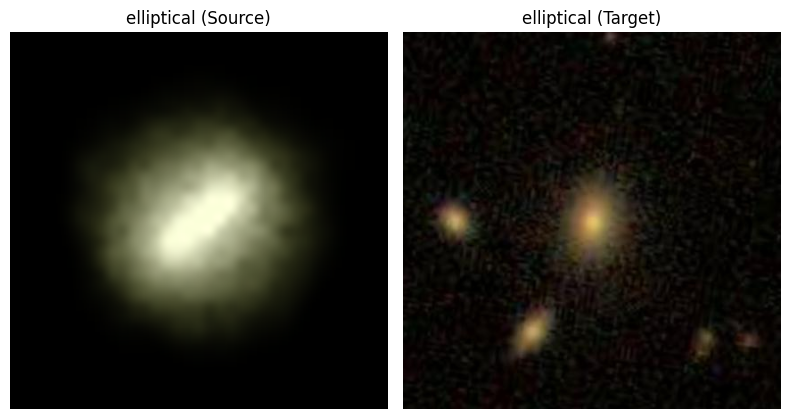

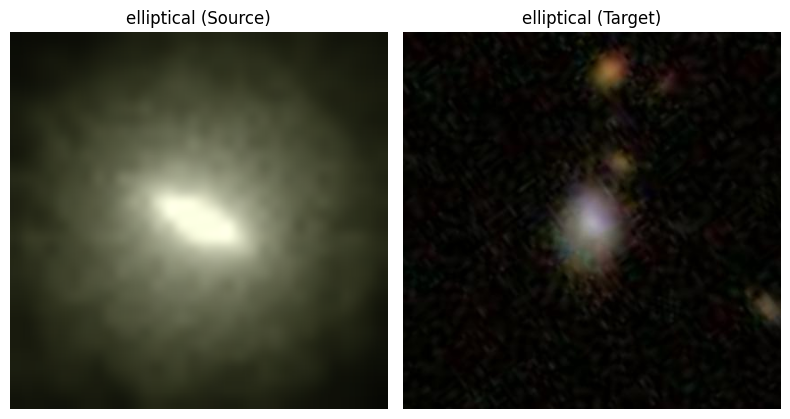

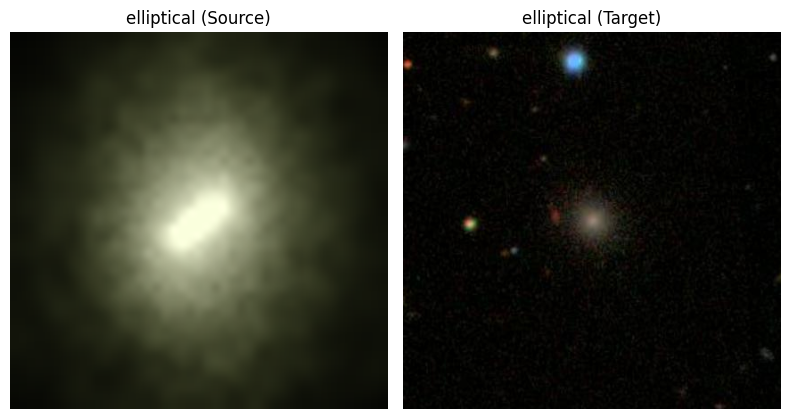

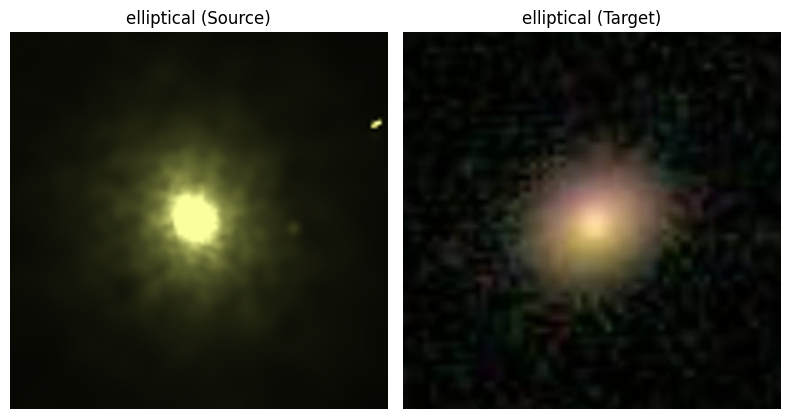

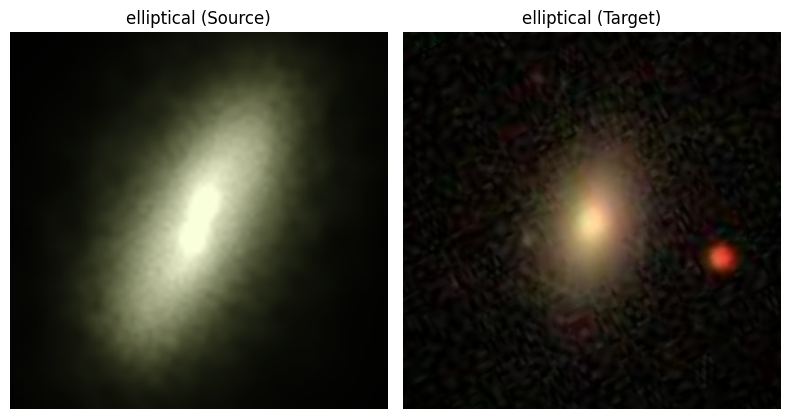

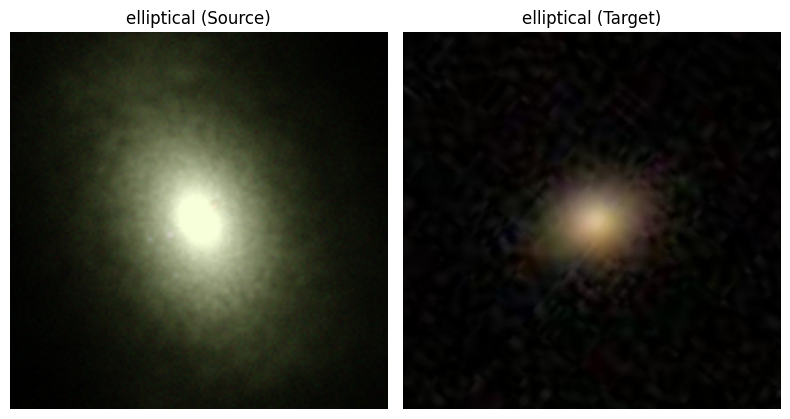

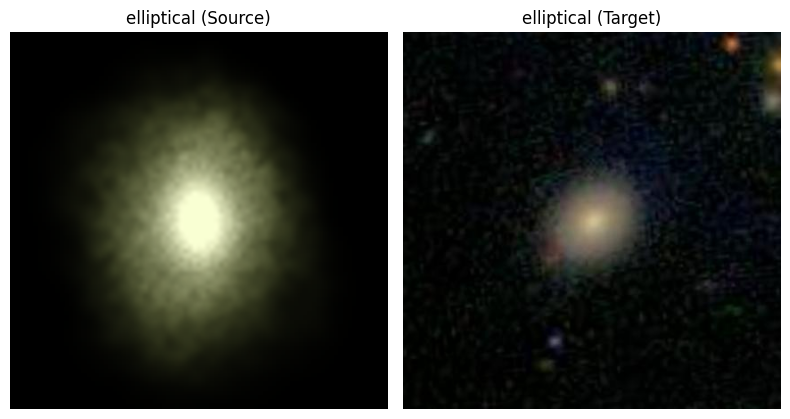

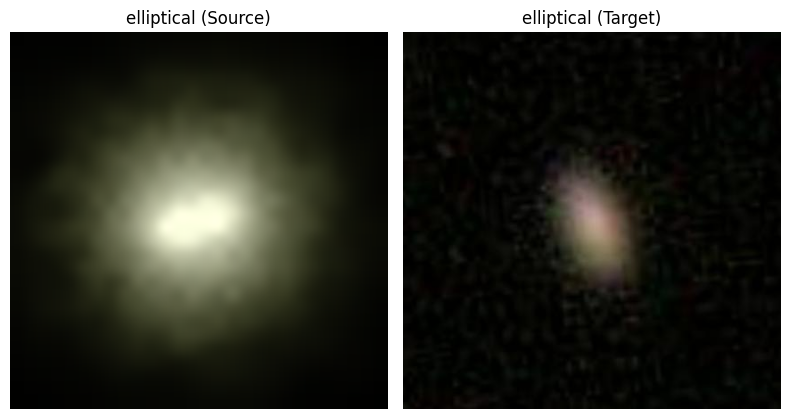

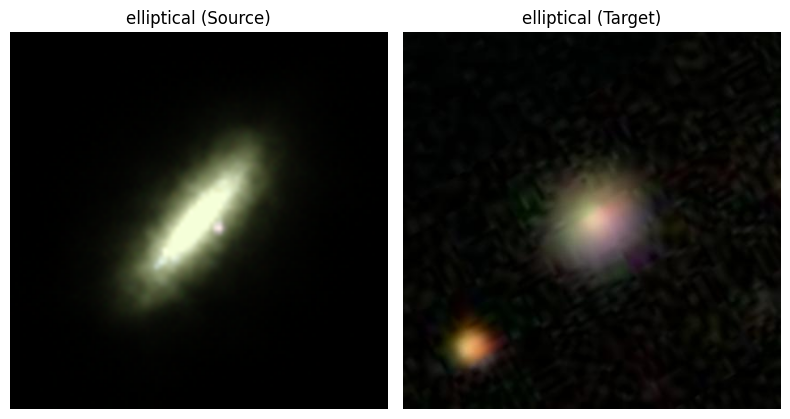

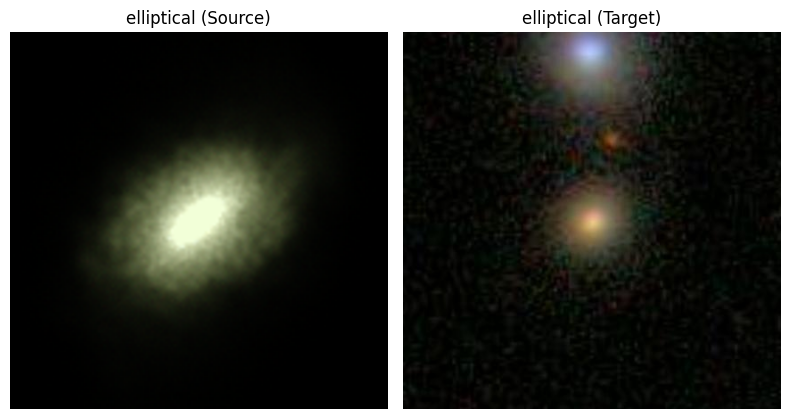

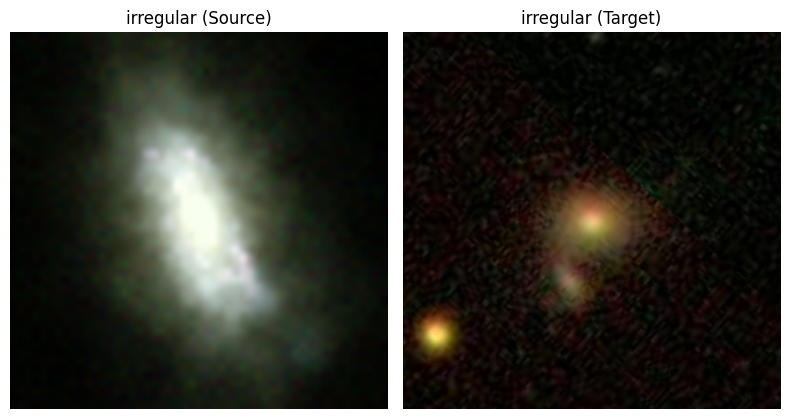

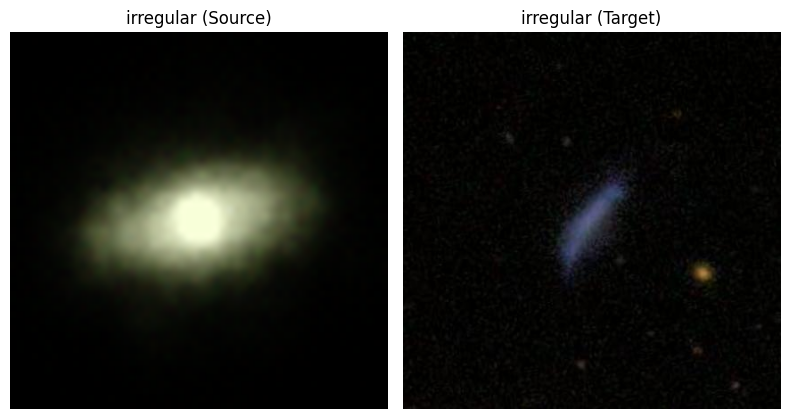

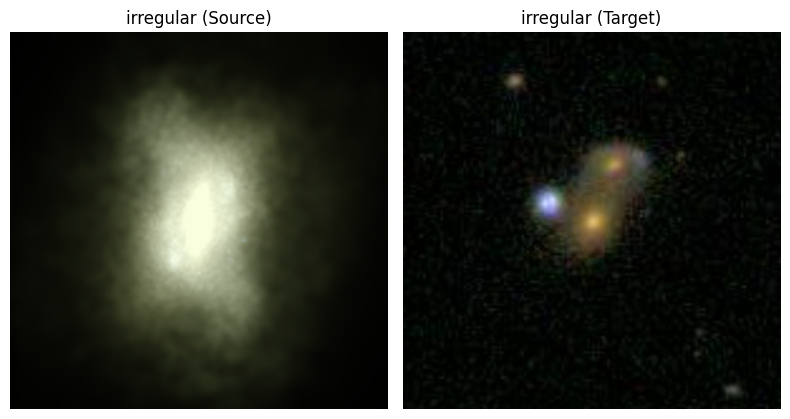

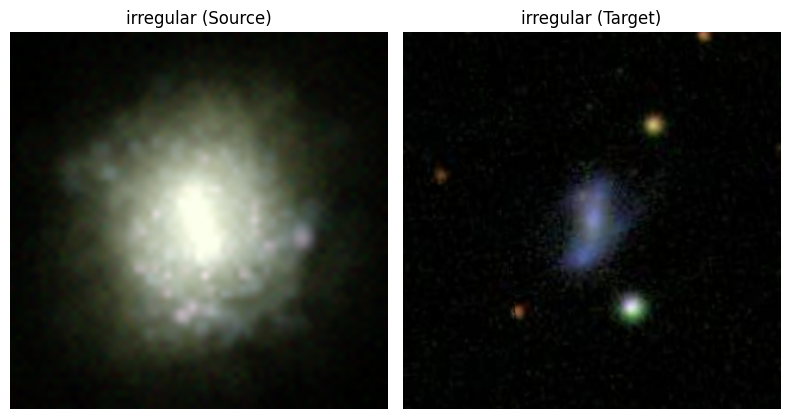

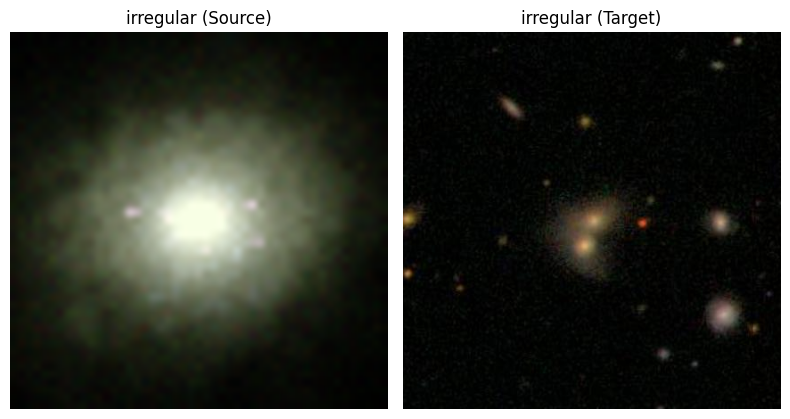

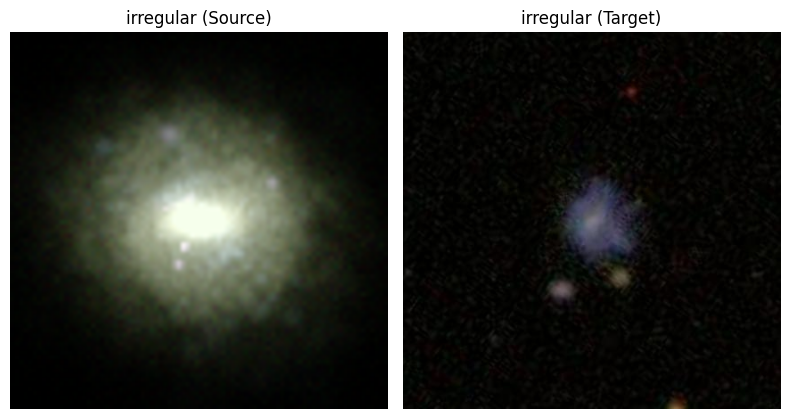

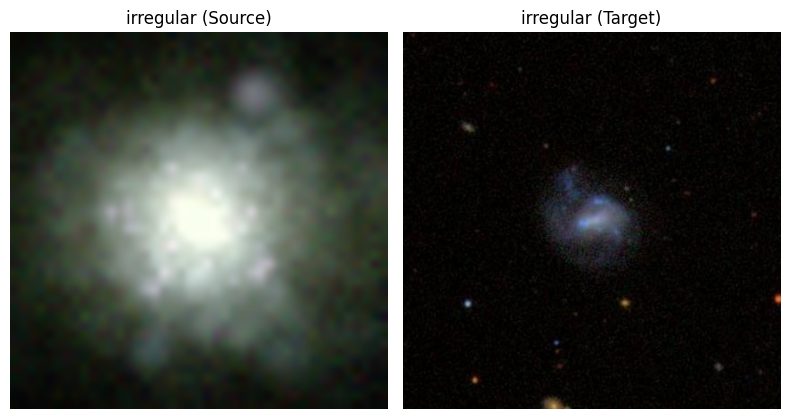

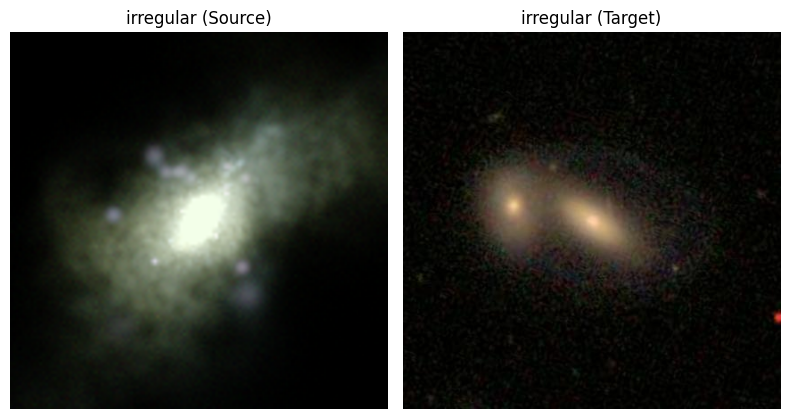

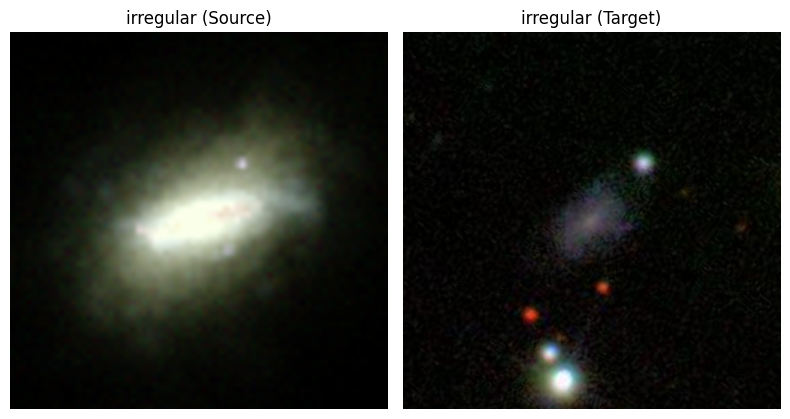

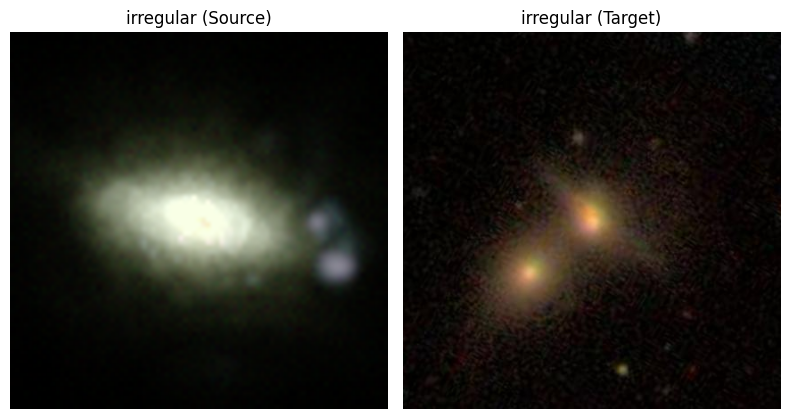

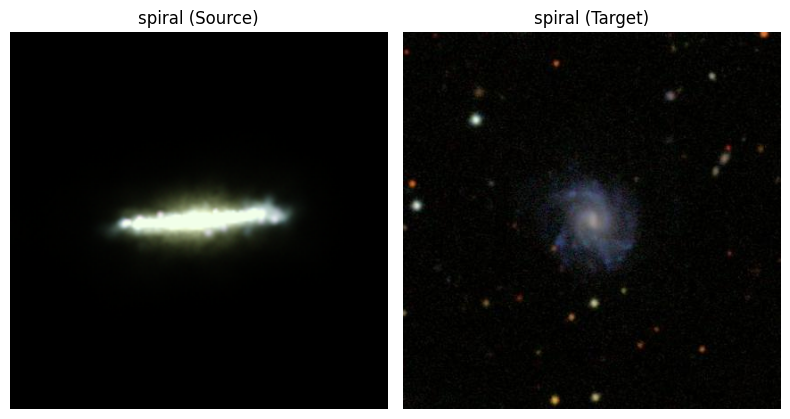

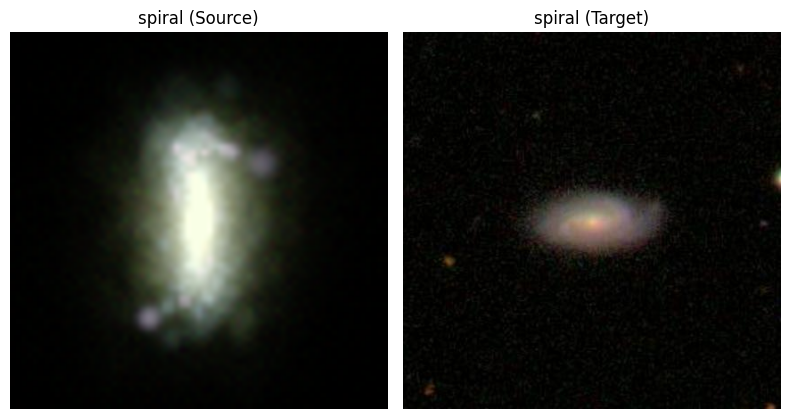

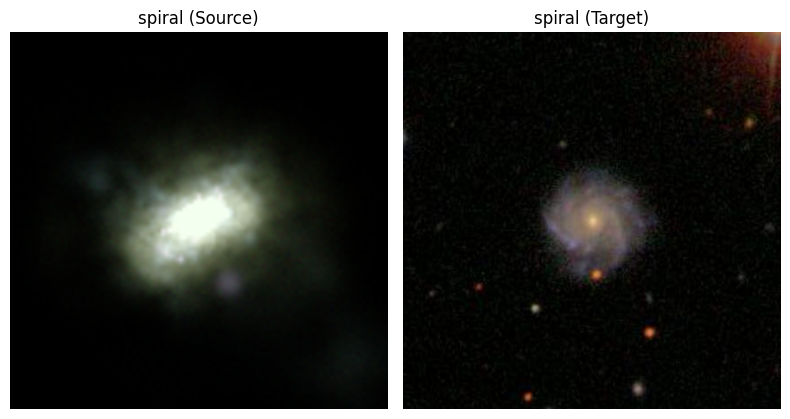

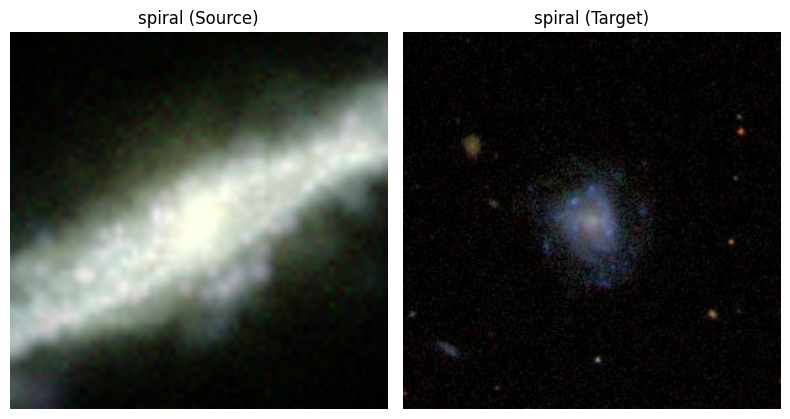

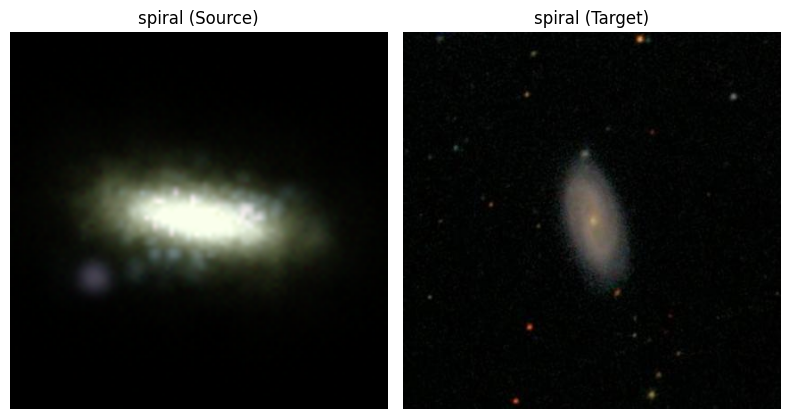

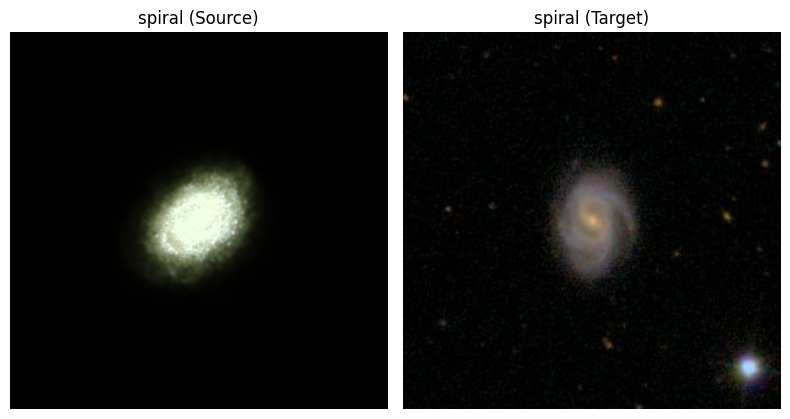

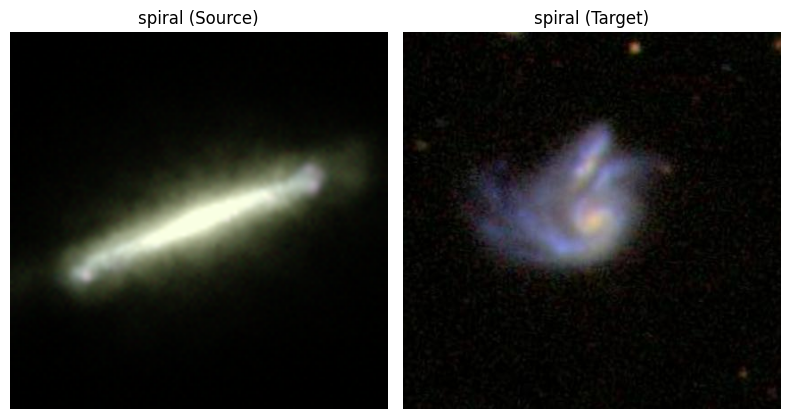

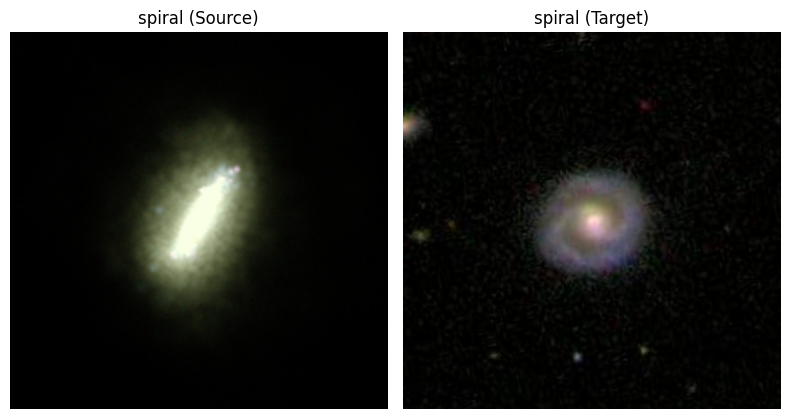

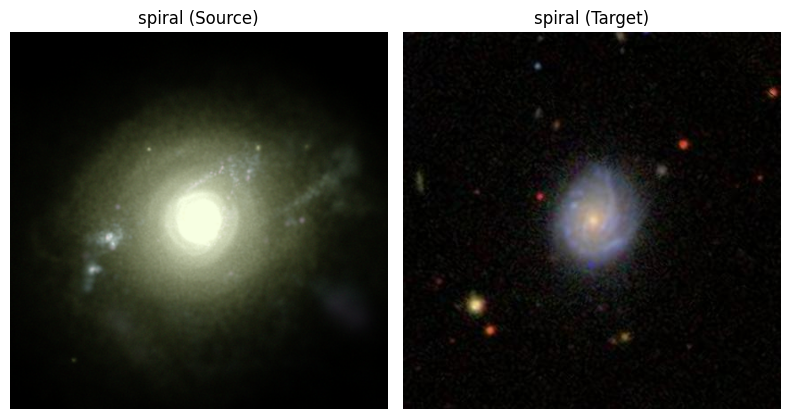

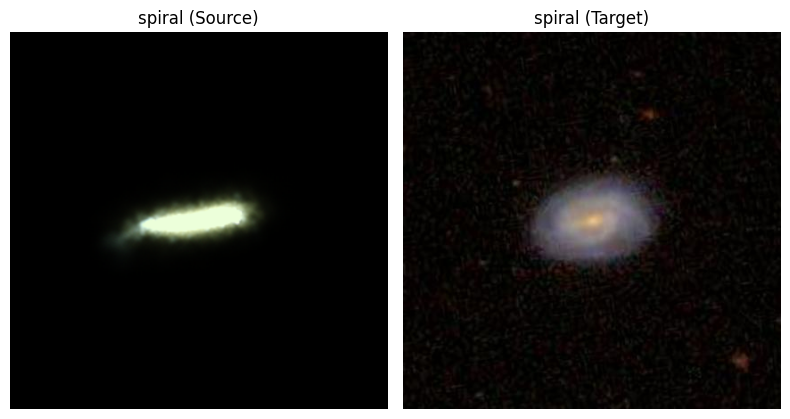

In [11]:
def plot_source_target_pairs(src_dataset, tgt_dataset, class_name, n=10):
    """
    Plot a pair of source and target images for a given class.

    Args:
        src_dataset (SourceDataset): source dataset
        tgt_dataset (TargetDataset): target dataset
        class_name (str): class name
        n (int): number of images to show for each class

    Returns:
        fig: matplotlib.figure.Figure
    """
    def get_label_id(dataset):
        return next(k for k, v in dataset.idx2label.items() if v == class_name)

    def get_samples(dataset, label_id):
        indices = [i for i, (_, y) in enumerate(dataset) if int(y) == label_id]
        return random.sample(indices, min(n, len(indices)))

    src_samples = get_samples(src_dataset, get_label_id(src_dataset))
    tgt_samples = get_samples(tgt_dataset, get_label_id(tgt_dataset))

    for i in range(0, len(src_samples), 1):
        chunk_src = src_samples[i:i + 1]
        chunk_tgt = tgt_samples[i:i + 1]

        fig, axs = plt.subplots(len(chunk_src), 2, figsize=(8, 8))
        if len(chunk_src) == 1:
            axs = np.array([axs])

        for j, (s_idx, t_idx) in enumerate(zip(chunk_src, chunk_tgt)):
            for ax, dataset, idx, label in zip(
                axs[j], [src_dataset, tgt_dataset], [s_idx, t_idx], ["Source", "Target"]
            ):
                img_pil, _ = dataset[idx]
                ax.imshow(img_pil)
                ax.axis("off")
                ax.set_title(f"{class_name} ({label})")

        plt.tight_layout()
        plt.show()


for class_name in src_labels: # or tgt_labels
    plot_source_target_pairs(src_train, tgt_train, class_name, n=10)